In [1]:
%run 0_3_configure_mlflow.ipynb

Experiment_id: 1
Artifact Location: file:///C:/Users/Piotrek/Documents/Inzynierka/csgo-analysis/mlruns/1
Tags: {}
Lifecycle_stage: active


In [2]:
import pandas as pd
import lightgbm as lgbm
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import os

from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, f1_score, RocCurveDisplay, roc_auc_score
from sklearn.calibration import CalibrationDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold, train_test_split

# Wczytanie danych

In [3]:
def select_feat():
    columns = [
        'seconds', 'ctAlivePlayers', 'ctEqVal', 'tAlivePlayers', 'tEqVal',
       'ct_armor', 't_armor', 'ct_hp', 't_hp', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade', 'ct_fireGrenades',
       't_fireGrenades', 'ct_isBlinded', 't_isBlinded', 'ct_hasDefuse',
       't_hasBomb', 'ct_isDefusing', 't_isPlanting', 'ct_spottedPlayers',
       't_spottedPlayers', 'ct_grouppedPlayers',
       'ct_meanDist', 'ct_minDist', 't_meanDist','t_minDist',
       't_grouppedPlayers', 'ct_conquerMap', 't_conquerMap', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_SniperRifle',
       'ct_activeWeapon_AssaultRifle', 'ct_activeWeapon_Others',
       't_activeWeapon_Pistol', 't_activeWeapon_EnhancedPistols',
       't_activeWeapon_Deagle', 't_activeWeapon_SMG',
       't_activeWeapon_WeakAssaultRifle', 't_activeWeapon_LunetRifle',
       't_activeWeapon_SniperRifle', 't_activeWeapon_AssaultRifle',
       't_activeWeapon_Others', 'ct_mainWeapon_Pistol',
       'ct_mainWeapon_EnhancedPistols', 'ct_mainWeapon_Deagle',
       'ct_mainWeapon_SMG', 'ct_mainWeapon_WeakAssaultRifle',
       'ct_mainWeapon_LunetRifle', 'ct_mainWeapon_SniperRifle',
       'ct_mainWeapon_AssaultRifle', 't_mainWeapon_Pistol', 't_mainWeapon_EnhancedPistols',
       't_mainWeapon_Deagle', 't_mainWeapon_SMG',
       't_mainWeapon_WeakAssaultRifle', 't_mainWeapon_LunetRifle',
       't_mainWeapon_SniperRifle', 't_mainWeapon_AssaultRifle', 
       'ct_secondaryWeapon_Pistol','ct_secondaryWeapon_EnhancedPistols', 'ct_secondaryWeapon_Deagle',
       't_secondaryWeapon_Pistol', 't_secondaryWeapon_EnhancedPistols',
       't_secondaryWeapon_Deagle', 'ctMinDistToA',
       'ctMinDistToB', 'tMinDistToA', 'tMinDistToB', 'ctMeanDistToA',
       'ctMeanDistToB', 'tMeanDistToA', 'tMeanDistToB', 'ctMeanKills',
       'tMeanKills', 'tScore', 'ctScore', 'de_ancient', 
       'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke', 'de_overpass',
       'de_vertigo','bombsite_A', 'bombsite_B', 'bombsite_not_planted'
    ]
    return columns

In [4]:
df = pd.read_parquet('data/ESTA_states_prepared.parquet', columns=select_feat() + ['demoId', 'roundNum'])
df

,seconds,ctAlivePlayers,ctEqVal,tAlivePlayers,tEqVal,ct_armor,t_armor,ct_hp,t_hp,ct_hasHelmet,...,de_inferno,de_mirage,de_nuke,de_overpass,de_vertigo,bombsite_A,bombsite_B,bombsite_not_planted,demoId,roundNum
0,0.007874,5,4400,5,4250,400,300,500,500,0,...,0,0,1,0,0,0,0,1,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
1,0.511811,5,4400,5,4250,400,300,500,500,0,...,0,0,1,0,0,0,0,1,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
2,1.015748,5,4400,5,4250,400,300,500,500,0,...,0,0,1,0,0,0,0,1,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
3,1.519685,5,4400,5,4250,400,300,500,500,0,...,0,0,1,0,0,0,0,1,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
4,2.023622,5,4400,5,4250,400,300,500,500,0,...,0,0,1,0,0,0,0,1,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7464293,81.464567,3,26800,1,24300,290,94,233,74,3,...,0,0,0,0,1,0,0,1,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464294,81.968504,3,26800,1,24300,290,94,233,74,3,...,0,0,0,0,1,0,0,1,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464295,82.472441,3,26800,1,24300,286,94,206,74,3,...,0,0,0,0,1,0,0,1,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464296,82.976378,2,26800,1,24300,194,94,159,74,2,...,0,0,0,0,1,0,0,1,ff910f54-0bed-4fdf-afa8-b481be09a788,26


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7464298 entries, 0 to 7464297
Columns: 101 entries, seconds to roundNum
dtypes: float64(17), int32(6), int64(67), object(1), uint8(10)
memory usage: 5.0+ GB


In [6]:
y = pd.read_parquet("data/ESTA_states_prepared.parquet", columns=["winningSideCT"])
y = y.squeeze()
y

0          0
1          0
2          0
3          0
4          0
          ..
7464293    1
7464294    1
7464295    1
7464296    1
7464297    1
Name: winningSideCT, Length: 7464298, dtype: int32

## Podział

In [7]:
groupped = df.groupby(['demoId', 'roundNum'])
demo_indexes = groupped.indices
np.random.seed(25)
samples_indexes = [values[np.random.randint(1, values.size)]
                  for key, values in demo_indexes.items()]
len(samples_indexes)

41074

In [8]:
X = df.drop(['demoId', 'roundNum'], axis='columns').iloc[samples_indexes]
y = y.iloc[samples_indexes]
X.shape, y.shape

((41074, 99), (41074,))

In [9]:
y.value_counts()

1    22158
0    18916
Name: winningSideCT, dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1) # 0.125 x 0.8 = 0.1
X_train.shape, X_val.shape, X_test.shape

((28751, 99), (4108, 99), (8215, 99))

In [11]:
y_test.value_counts(normalize=True)

1    0.541327
0    0.458673
Name: winningSideCT, dtype: float64

In [13]:
parameters = {
    "num_leaves": Integer(4, 70),
    "max_depth": Integer(2, 80),
    "n_estimators": Integer(100, 1300),
    "subsample": Real(0.6, 1),
    "subsample_freq": Integer(0, 2)
}

opt = BayesSearchCV(lgbm.LGBMClassifier(n_jobs=4),
                    search_spaces=parameters,
                    scoring="neg_log_loss",
                    n_iter=50,
                    n_jobs=1,
                    fit_params={"eval_set": [(X_val, y_val)]},
                    cv=StratifiedKFold(n_splits=4),
                    verbose=1,
                    random_state=42,
                    refit=True)
opt.fit(X_train, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Fitting 4 folds for each of 1 candidates, totalling 4 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
              estimator=LGBMClassifier(n_jobs=4),
              fit_params={'eval_set': [(           seconds  ctAlivePlayers  ctEqVal  tAlivePlayers  tEqVal  ct_armor  \
775029   54.850394               4    31950              5   23900       397   
3260692  15.054688               5    14050              5   27550       500   
3695102  20.195312               3    27800              1   22900       296   
3853664  75.307087               5    10650              4   21300       396   
4678639  19.803150               1    30300              5   25450        95   
...            ....
              search_spaces={'max_depth': Integer(low=2, high=80, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1300, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=4, high=70, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1, prior='uniform', transform='normalize'),
                             'subsample_freq': Integer(low=0, high=2, prior='uniform', transform='normalize')},
              verbose=1)

In [14]:
res = pd.DataFrame(opt.cv_results_)
res.sort_values(by="mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_num_leaves,param_subsample,param_subsample_freq,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
25,2.248185,0.059665,0.154964,5.764901e-04,36,1091,70,0.622148,1,"{'max_depth': 36, 'n_estimators': 1091, 'num_l...",-0.640854,-0.622074,-0.665645,-0.636528,-0.641275,0.015695,50
0,1.913155,0.039914,0.117915,9.113724e-04,34,973,66,0.72632,1,"{'max_depth': 34, 'n_estimators': 973, 'num_le...",-0.582064,-0.565935,-0.610147,-0.590254,-0.587100,0.015925,49
8,1.716370,0.042002,0.105778,1.419942e-03,77,941,62,0.766328,1,"{'max_depth': 77, 'n_estimators': 941, 'num_le...",-0.553268,-0.540466,-0.583679,-0.564535,-0.560487,0.015868,48
7,1.454567,0.039500,0.098713,6.451998e-04,44,1204,37,0.935063,1,"{'max_depth': 44, 'n_estimators': 1204, 'num_l...",-0.503312,-0.507272,-0.533273,-0.512202,-0.514015,0.011556,47
46,1.233127,0.011885,0.099168,1.114168e-03,9,1269,26,0.782527,1,"{'max_depth': 9, 'n_estimators': 1269, 'num_le...",-0.483872,-0.486333,-0.508561,-0.487124,-0.491473,0.009938,46
14,1.203738,0.025502,0.079060,1.544477e-03,73,1107,30,0.981715,1,"{'max_depth': 73, 'n_estimators': 1107, 'num_l...",-0.478383,-0.474918,-0.500814,-0.479211,-0.483332,0.010221,45
6,1.050354,0.023837,0.072612,2.253212e-03,50,1030,28,0.94973,1,"{'max_depth': 50, 'n_estimators': 1030, 'num_l...",-0.463982,-0.461075,-0.486233,-0.475220,-0.471628,0.009950,44
1,1.516827,0.041665,0.075295,5.497208e-04,67,1160,24,0.98049,2,"{'max_depth': 67, 'n_estimators': 1160, 'num_l...",-0.460349,-0.467794,-0.483846,-0.472101,-0.471023,0.008514,43
4,1.091880,0.029155,0.050108,1.665658e-03,64,626,39,0.886285,2,"{'max_depth': 64, 'n_estimators': 626, 'num_le...",-0.455865,-0.456888,-0.474753,-0.462131,-0.462409,0.007513,42
5,1.270142,0.049188,0.079112,1.841614e-03,59,1227,15,0.67537,2,"{'max_depth': 59, 'n_estimators': 1227, 'num_l...",-0.457972,-0.458121,-0.469994,-0.461138,-0.461806,0.004893,41


In [16]:
model_lgbm = opt.best_estimator_
explainer = shap.TreeExplainer(model_lgbm)
shap_values = explainer(X_test)

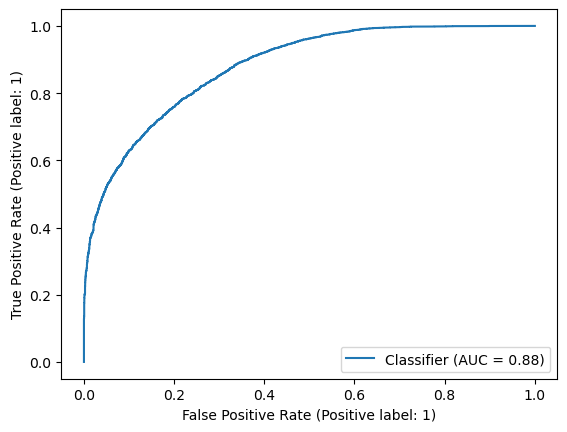

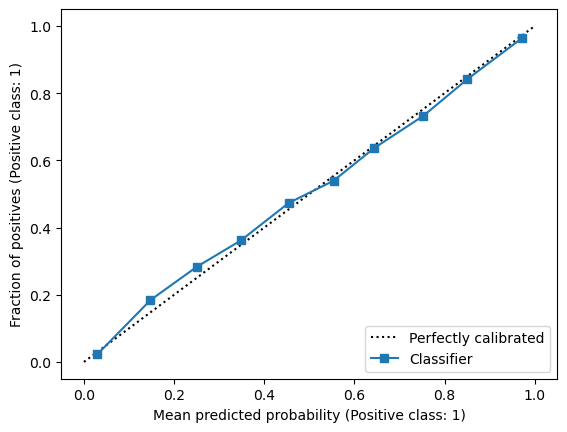

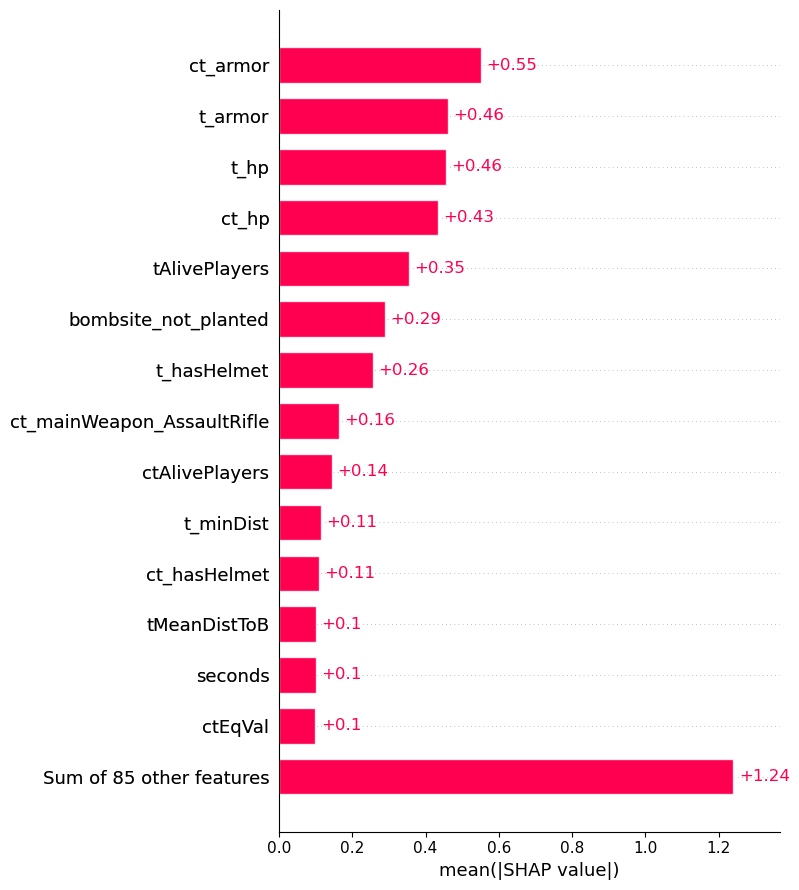

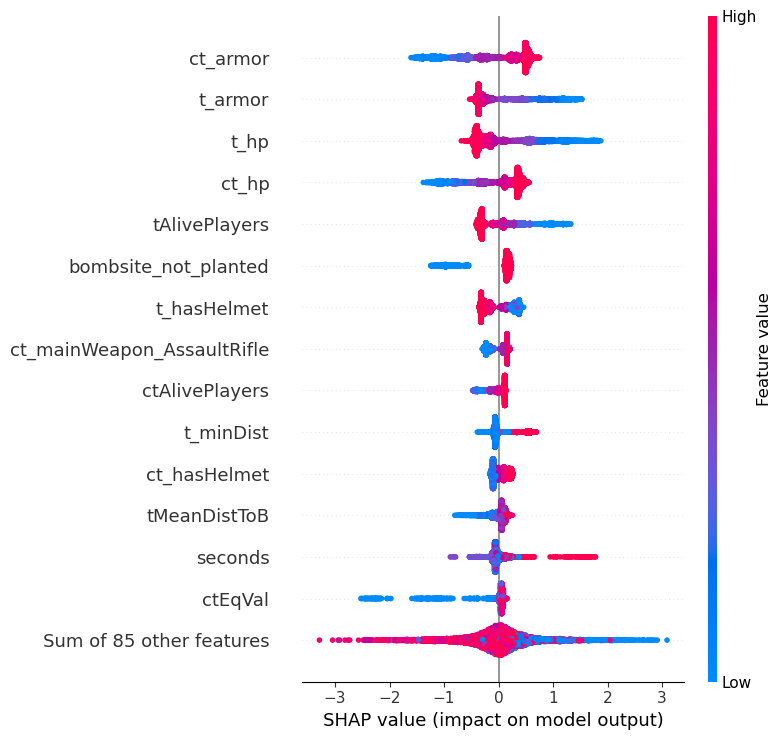

In [17]:
run_name = "LGBM - ESTA improvement"
additional_description = "LGBM ESTA improvement"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_params(model_lgbm.get_params())
        mlflow.log_param("X_train.shape", X_train.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_params({f"{key}_space": parameters[key] for key in parameters})

        y_proba = model_lgbm.predict_proba(X_test)[:, 1]
        y_true = y_test
        features_names = model_lgbm.feature_name_
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        
        os.makedirs('artifacts', exist_ok=True)
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        os.makedirs('models', exist_ok=True)
        with open("models/model.pkl", "wb") as f:
            pickle.dump(model_lgbm, f)

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.jpg')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.jpg')
        plt.show()
        
        shap.plots.bar(shap_values[:, :, 1], show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_importance.jpg')
        plt.show()
        
        shap.plots.beeswarm(shap_values[:, :, 1], show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_beeplot.jpg')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")

In [21]:
test_df = pd.read_parquet("data/states_another_mod_test.parquet", columns=select_feat() + ["filename"])
past = test_df['filename'].str.startswith("IEM-Katowice")
future = test_df['filename'].str.startswith("BLAST-Premier-Spring-Final-2022")
test_y = pd.read_parquet("data/states_another_mod_test.parquet", columns=["winningSideCT"])
test_y = test_y.squeeze()
test_df.shape

(620392, 100)

In [23]:
results = []
y_true = test_y
y_pred = model_lgbm.predict_proba(test_df.drop("filename", axis="columns"))[:, 1]
results = {
        "LogLoss (all)": log_loss(y_true, y_pred),
        "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
        "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
}
results

{'LogLoss (all)': 0.4680032272526439,
 'LogLoss (future)': 0.46557910889759657,
 'LogLoss (past)': 0.4702635686224433,
 'AUC-ROC (all)': 0.8483651713266162,
 'AUC-ROC (future)': 0.8521439140803679,
 'AUC-ROC (past)': 0.8444266487165619}

# Większy sampling

## Podział

In [53]:
groupped = df.groupby(['demoId', 'roundNum'])
demo_indexes = groupped.indices
np.random.seed(25)
how_many = 10
samples_indexes = {key: [values[np.random.randint(1, values.size)]
                   for i in range(how_many)]
                      for key, values in demo_indexes.items()}
len(samples_indexes)

41074

In [54]:
maps = len(samples_indexes.keys())
np.random.seed(12)
train_ind = np.random.choice(maps, size=int(0.8*maps), replace=False)
train_indexes = np.array([])
test_indexes = np.array([])
for i, key in enumerate(samples_indexes):
    if i not in train_ind:
        test_indexes = np.concatenate((test_indexes, samples_indexes[key]))

test_indexes.shape

(82150,)

In [55]:
maps = len(samples_indexes.keys())
np.random.seed(12)
train_ind = np.random.choice(train_ind, size=int(0.875*train_ind.size), replace=False)
train_indexes = np.array([])
valid_indexes = np.array([])
for i, key in enumerate(samples_indexes):
    if i in train_ind:
        train_indexes = np.concatenate((train_indexes, samples_indexes[key]))
    else:
        valid_indexes = np.concatenate((valid_indexes, samples_indexes[key]))

train_indexes.shape, valid_indexes.shape

((287510,), (123230,))

In [56]:
X = df.drop(['demoId', 'roundNum'], axis='columns')
y = pd.read_parquet("data/ESTA_states_prepared.parquet", columns=["winningSideCT"])
y = y.squeeze()

In [57]:
y.value_counts()

1    3875902
0    3588396
Name: winningSideCT, dtype: int64

In [58]:
X_train, X_test, y_train, y_test = X.iloc[train_indexes], X.iloc[test_indexes], y.iloc[train_indexes], y.iloc[test_indexes]
X_val, y_val = X.iloc[valid_indexes], y.iloc[valid_indexes]
X_train.shape, X_val.shape, X_test.shape

((287510, 99), (123230, 99), (82150, 99))

In [59]:
y_train.value_counts(normalize=True), y_val.value_counts(normalize=True), y_test.value_counts(normalize=True)

(1    0.540607
 0    0.459393
 Name: winningSideCT, dtype: float64,
 1    0.536801
 0    0.463199
 Name: winningSideCT, dtype: float64,
 1    0.535484
 0    0.464516
 Name: winningSideCT, dtype: float64)

In [60]:
parameters = {
    "num_leaves": Integer(4, 70),
    "max_depth": Integer(2, 80),
    "n_estimators": Integer(100, 1300),
    "subsample": Real(0.6, 1),
    "subsample_freq": Integer(0, 2)
}

opt = BayesSearchCV(lgbm.LGBMClassifier(n_jobs=4),
                    search_spaces=parameters,
                    scoring="neg_log_loss",
                    n_iter=50,
                    n_jobs=1,
                    fit_params={"eval_set": [(X_val, y_val)]},
                    cv=StratifiedKFold(n_splits=3),
                    verbose=1,
                    random_state=42,
                    refit=True)
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
              estimator=LGBMClassifier(n_jobs=4),
              fit_params={'eval_set': [(            seconds  ctAlivePlayers  ctEqVal  tAlivePlayers  tEqVal  ct_armor  \
4126093   80.944882               2    12650              1   19400       178   
4126131  100.094488               2    12650              1   19400       178   
4126063   65.826772               2    12650              1   19400       178   
4126101   84.976378               2    12650              1   19400       178   
4125937    2.330709               5    10450              5   19700       500   
.....
              search_spaces={'max_depth': Integer(low=2, high=80, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1300, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=4, high=70, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1, prior='uniform', transform='normalize'),
                             'subsample_freq': Integer(low=0, high=2, prior='uniform', transform='normalize')},
              verbose=1)

In [61]:
res = pd.DataFrame(opt.cv_results_)
res.sort_values(by="mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_num_leaves,param_subsample,param_subsample_freq,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
14,5.061409,0.008232,1.209954,1.231477e-02,44,1070,66,0.609931,1,"{'max_depth': 44, 'n_estimators': 1070, 'num_l...",-0.454594,-0.459929,-0.452418,-0.455647,0.003156,50
15,5.010246,0.034593,1.402311,8.612255e-03,9,1161,53,0.690663,1,"{'max_depth': 9, 'n_estimators': 1161, 'num_le...",-0.448915,-0.456517,-0.445321,-0.450251,0.004667,49
0,4.955897,0.050280,0.987495,1.294957e-02,34,973,66,0.72632,1,"{'max_depth': 34, 'n_estimators': 973, 'num_le...",-0.450192,-0.450825,-0.444107,-0.448375,0.003029,48
18,4.665400,0.003255,1.142181,8.259129e-03,12,1082,53,0.614646,1,"{'max_depth': 12, 'n_estimators': 1082, 'num_l...",-0.447309,-0.452575,-0.444836,-0.448240,0.003227,47
12,5.079681,0.030820,1.771410,5.168159e-03,6,1114,58,0.862769,1,"{'max_depth': 6, 'n_estimators': 1114, 'num_le...",-0.446122,-0.449926,-0.439820,-0.445290,0.004168,46
8,4.531183,0.006626,0.896003,1.480619e-02,77,941,62,0.766328,1,"{'max_depth': 77, 'n_estimators': 941, 'num_le...",-0.447919,-0.447967,-0.439509,-0.445131,0.003976,45
16,4.520551,0.036920,1.020255,9.361418e-03,33,1064,50,0.672353,1,"{'max_depth': 33, 'n_estimators': 1064, 'num_l...",-0.444496,-0.447259,-0.440565,-0.444107,0.002747,44
17,4.790648,0.018863,0.970754,8.134201e-04,58,1079,54,0.889765,1,"{'max_depth': 58, 'n_estimators': 1079, 'num_l...",-0.445123,-0.447723,-0.438303,-0.443716,0.003972,43
13,4.129525,0.030766,0.878064,9.866666e-03,19,957,50,0.648747,1,"{'max_depth': 19, 'n_estimators': 957, 'num_le...",-0.441179,-0.446009,-0.436333,-0.441174,0.003950,42
7,4.748028,0.005121,0.987033,6.920941e-03,44,1204,37,0.935063,1,"{'max_depth': 44, 'n_estimators': 1204, 'num_l...",-0.441878,-0.442356,-0.434093,-0.439442,0.003787,41


In [62]:
model_lgbm = opt.best_estimator_
explainer = shap.TreeExplainer(model_lgbm)
shap_values = explainer(X_test)

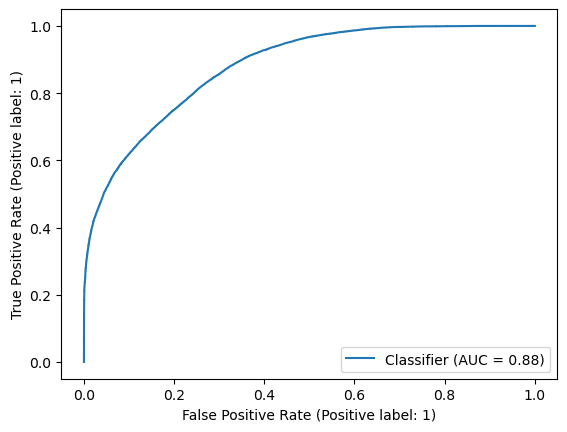

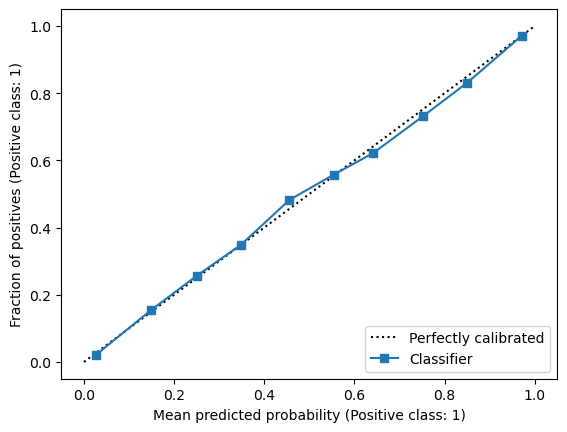

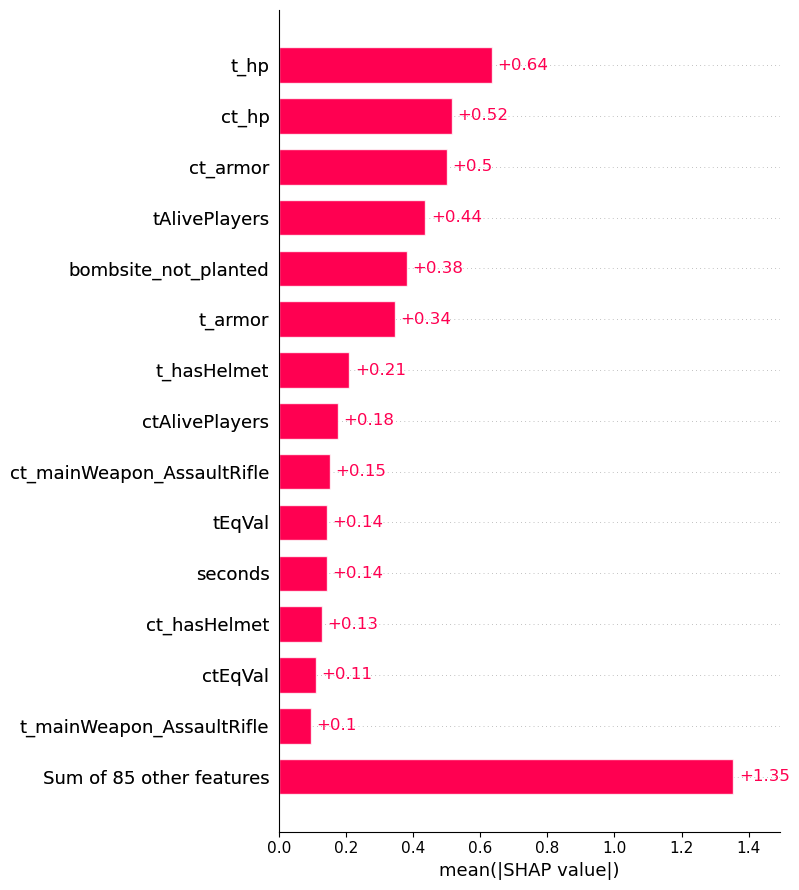

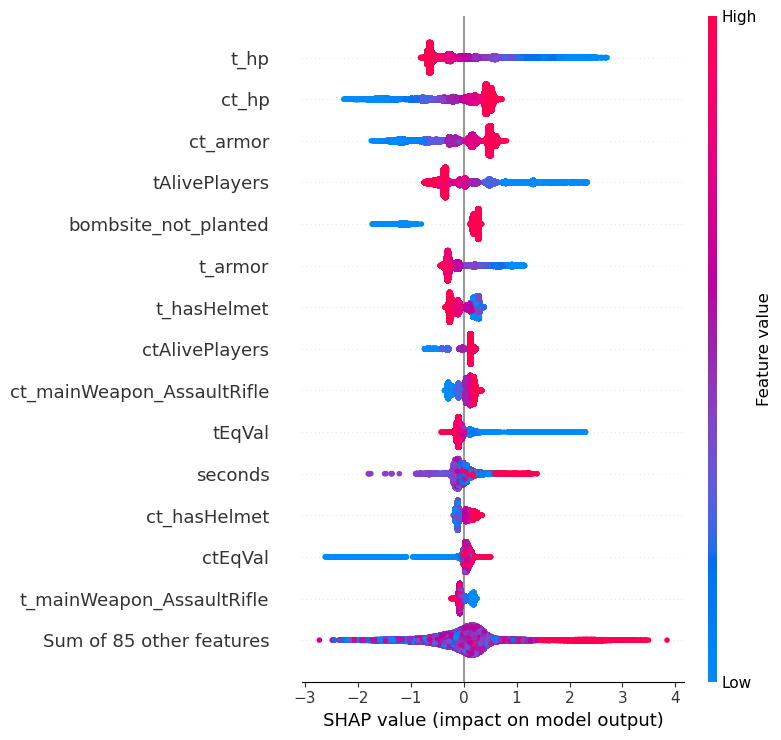

In [63]:
run_name = "LGBM - ESTA 10 samples"
additional_description = "LGBM ESTA 10 samples"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_params(model_lgbm.get_params())
        mlflow.log_param("X_train.shape", X_train.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_params({f"{key}_space": parameters[key] for key in parameters})

        y_proba = model_lgbm.predict_proba(X_test)[:, 1]
        y_true = y_test
        features_names = model_lgbm.feature_name_
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        
        os.makedirs('artifacts', exist_ok=True)
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        os.makedirs('models', exist_ok=True)
        with open("models/model.pkl", "wb") as f:
            pickle.dump(model_lgbm, f)

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.jpg')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.jpg')
        plt.show()
        
        shap.plots.bar(shap_values[:, :, 1], show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_importance.jpg')
        plt.show()
        
        shap.plots.beeswarm(shap_values[:, :, 1], show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_beeplot.jpg')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")

In [64]:
test_df = pd.read_parquet("data/states_another_mod_test.parquet", columns=select_feat() + ["filename"])
past = test_df['filename'].str.startswith("IEM-Katowice")
future = test_df['filename'].str.startswith("BLAST-Premier-Spring-Final-2022")
test_y = pd.read_parquet("data/states_another_mod_test.parquet", columns=["winningSideCT"])
test_y = test_y.squeeze()
test_df.shape

(620392, 100)

In [65]:
results = []
y_true = test_y
y_pred = model_lgbm.predict_proba(test_df.drop("filename", axis="columns"))[:, 1]
results = {
        "LogLoss (all)": log_loss(y_true, y_pred),
        "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
        "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
}
results

{'LogLoss (all)': 0.46257978839544134,
 'LogLoss (future)': 0.4639185797482786,
 'LogLoss (past)': 0.46133144774654233,
 'AUC-ROC (all)': 0.8541965245176402,
 'AUC-ROC (future)': 0.8538563282195393,
 'AUC-ROC (past)': 0.8535062426958299}

# All dataset

In [67]:
groupped = df.groupby(['demoId'])
samples_indexes = groupped.indices
len(samples_indexes)

1558

In [68]:
maps = len(samples_indexes.keys())
np.random.seed(12)
train_ind = np.random.choice(maps, size=int(0.8*maps), replace=False)
train_indexes = np.array([])
test_indexes = np.array([])
for i, key in enumerate(samples_indexes):
    if i not in train_ind:
        test_indexes = np.concatenate((test_indexes, samples_indexes[key]))

test_indexes.shape

(1500668,)

In [69]:
maps = len(samples_indexes.keys())
np.random.seed(12)
train_ind = np.random.choice(train_ind, size=int(0.875*train_ind.size), replace=False)
train_indexes = np.array([])
valid_indexes = np.array([])
for i, key in enumerate(samples_indexes):
    if i in train_ind:
        train_indexes = np.concatenate((train_indexes, samples_indexes[key]))
    else:
        valid_indexes = np.concatenate((valid_indexes, samples_indexes[key]))

train_indexes.shape, valid_indexes.shape

((5226658,), (2237640,))

In [70]:
X = df.drop(['demoId', 'roundNum'], axis='columns')
y = pd.read_parquet("data/ESTA_states_prepared.parquet", columns=["winningSideCT"])
y = y.squeeze()

In [71]:
y.value_counts()

1    3875902
0    3588396
Name: winningSideCT, dtype: int64

In [72]:
X_train, X_test, y_train, y_test = X.iloc[train_indexes], X.iloc[test_indexes], y.iloc[train_indexes], y.iloc[test_indexes]
X_val, y_val = X.iloc[valid_indexes], y.iloc[valid_indexes]
X_train.shape, X_val.shape, X_test.shape

((5226658, 99), (2237640, 99), (1500668, 99))

In [73]:
y_train.value_counts(normalize=True), y_val.value_counts(normalize=True), y_test.value_counts(normalize=True)

(1    0.519761
 0    0.480239
 Name: winningSideCT, dtype: float64,
 1    0.518086
 0    0.481914
 Name: winningSideCT, dtype: float64,
 1    0.511272
 0    0.488728
 Name: winningSideCT, dtype: float64)

In [74]:
parameters = {
    "num_leaves": Integer(4, 70),
    "max_depth": Integer(2, 80),
    "n_estimators": Integer(100, 1300),
    "subsample": Real(0.6, 1),
    "subsample_freq": Integer(0, 2)
}

opt = BayesSearchCV(lgbm.LGBMClassifier(n_jobs=4),
                    search_spaces=parameters,
                    scoring="neg_log_loss",
                    n_iter=50,
                    n_jobs=1,
                    fit_params={"eval_set": [(X_val, y_val)]},
                    cv=StratifiedKFold(n_splits=3),
                    verbose=1,
                    random_state=42,
                    refit=True)
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
              estimator=LGBMClassifier(n_jobs=4),
              fit_params={'eval_set': [(          seconds  ctAlivePlayers  ctEqVal  tAlivePlayers  tEqVal  ct_armor  \
5636     0.472441               5     4400              5    3700       400   
5637     0.976378               5     4400              5    3700       400   
5638     1.480315               5     4400              5    4400       400   
5639     1.984252               5     4400              5    4400       400   
5640     2.488189               5     4400              5    4400       400   
...           ...             ...      ...            ...     ...       ...   
7459824  4.43...
              search_spaces={'max_depth': Integer(low=2, high=80, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1300, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=4, high=70, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1, prior='uniform', transform='normalize'),
                             'subsample_freq': Integer(low=0, high=2, prior='uniform', transform='normalize')},
              verbose=1)

In [75]:
res = pd.DataFrame(opt.cv_results_)
res.sort_values(by="mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_num_leaves,param_subsample,param_subsample_freq,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
27,65.765312,0.457105,15.684262,0.674085,38,1300,54,0.906264,1,"{'max_depth': 38, 'n_estimators': 1300, 'num_l...",-0.483995,-0.483624,-0.479471,-0.482363,0.002051,50
0,53.129143,2.517943,10.688280,0.345421,34,973,66,0.72632,1,"{'max_depth': 34, 'n_estimators': 973, 'num_le...",-0.480852,-0.479467,-0.476790,-0.479036,0.001686,49
11,66.204289,0.149199,25.674314,0.073220,6,1117,59,0.876775,1,"{'max_depth': 6, 'n_estimators': 1117, 'num_le...",-0.478688,-0.477189,-0.480130,-0.478669,0.001201,48
13,53.478575,0.156455,11.502612,0.297326,78,1099,50,0.742687,0,"{'max_depth': 78, 'n_estimators': 1099, 'num_l...",-0.479008,-0.478508,-0.477273,-0.478263,0.000729,47
8,49.274496,0.175515,9.947285,0.211699,77,941,62,0.766328,1,"{'max_depth': 77, 'n_estimators': 941, 'num_le...",-0.480342,-0.476787,-0.474380,-0.477170,0.002449,46
37,56.306171,0.157460,11.481402,0.374034,16,1069,55,0.945298,1,"{'max_depth': 16, 'n_estimators': 1069, 'num_l...",-0.477402,-0.478363,-0.475236,-0.477000,0.001308,45
7,59.833624,0.275006,11.959882,0.479165,44,1204,37,0.935063,1,"{'max_depth': 44, 'n_estimators': 1204, 'num_l...",-0.473951,-0.474026,-0.471869,-0.473282,0.001000,44
18,55.504164,0.287124,6.260244,0.114110,40,615,69,0.637705,2,"{'max_depth': 40, 'n_estimators': 615, 'num_le...",-0.468251,-0.467254,-0.465087,-0.466864,0.001321,43
10,61.026120,0.206978,6.574120,0.171311,31,703,50,0.653894,2,"{'max_depth': 31, 'n_estimators': 703, 'num_le...",-0.464811,-0.465887,-0.461995,-0.464231,0.001641,42
6,51.501383,0.312147,9.071733,0.256355,50,1030,28,0.94973,1,"{'max_depth': 50, 'n_estimators': 1030, 'num_l...",-0.462742,-0.464517,-0.460793,-0.462684,0.001521,41


In [76]:
model_lgbm = opt.best_estimator_
explainer = shap.TreeExplainer(model_lgbm)
shap_values = explainer(X_test)

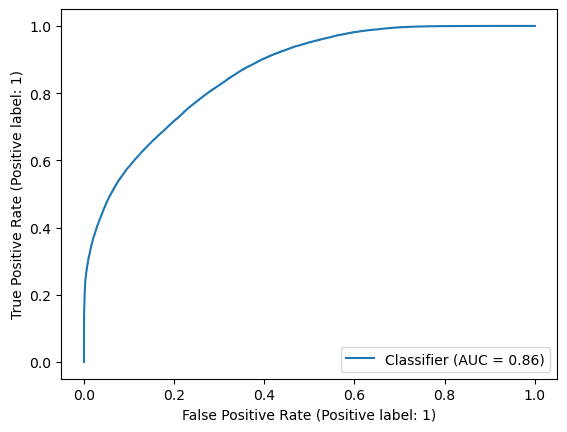

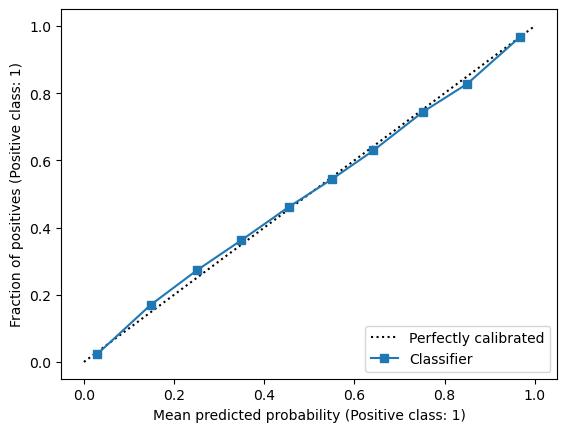

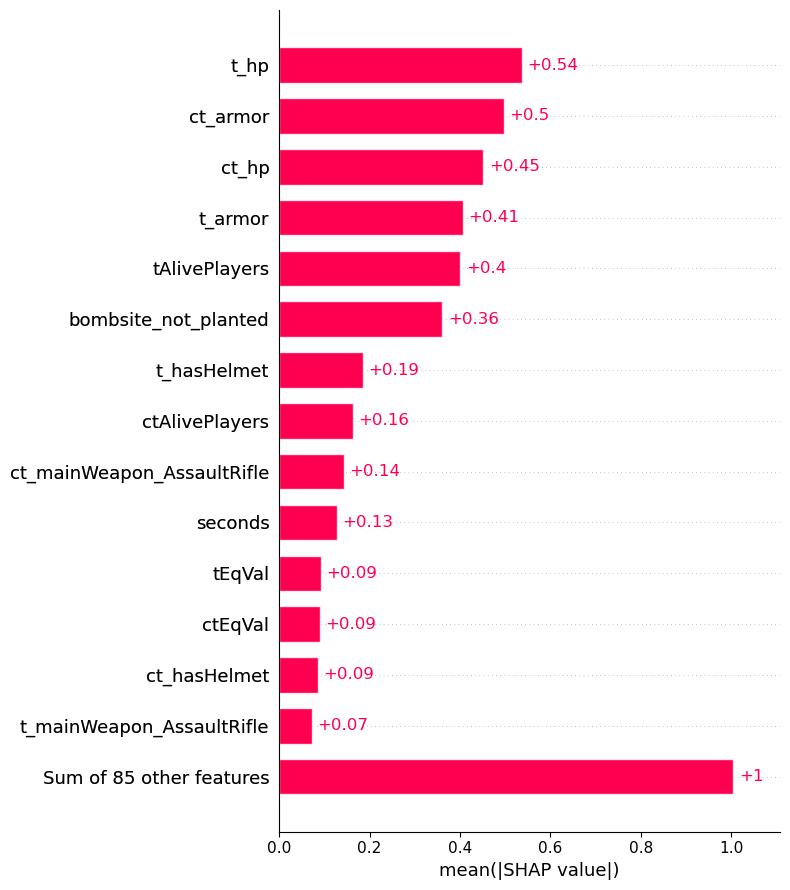

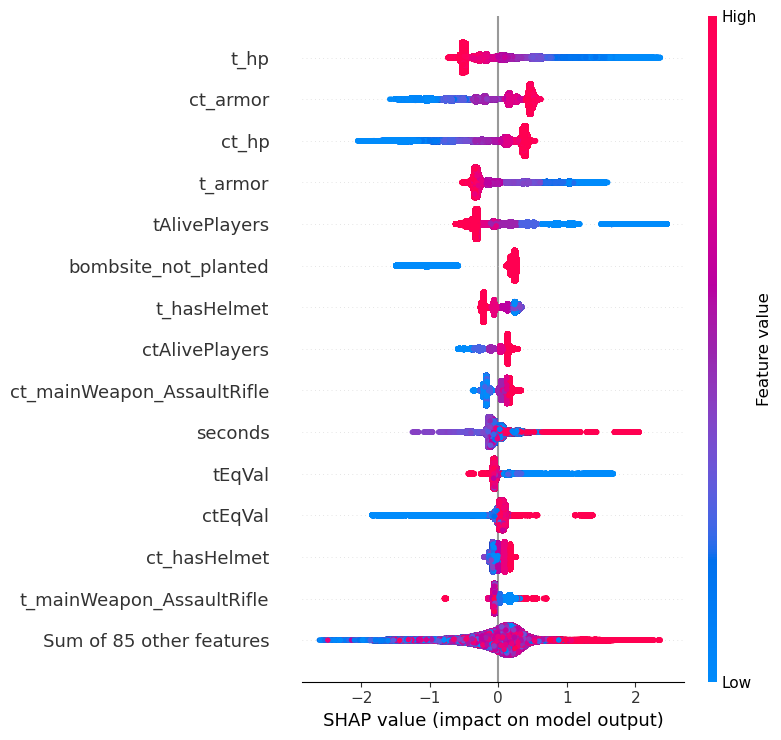

In [77]:
run_name = "LGBM - ESTA All Dataset"
additional_description = "LGBM ESTA All Dataset"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_params(model_lgbm.get_params())
        mlflow.log_param("X_train.shape", X_train.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_params({f"{key}_space": parameters[key] for key in parameters})

        y_proba = model_lgbm.predict_proba(X_test)[:, 1]
        y_true = y_test
        features_names = model_lgbm.feature_name_
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        
        os.makedirs('artifacts', exist_ok=True)
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        os.makedirs('models', exist_ok=True)
        with open("models/model.pkl", "wb") as f:
            pickle.dump(model_lgbm, f)

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.jpg')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.jpg')
        plt.show()
        
        shap.plots.bar(shap_values[:, :, 1], show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_importance.jpg')
        plt.show()
        
        shap.plots.beeswarm(shap_values[:, :, 1], show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_beeplot.jpg')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")

In [78]:
test_df = pd.read_parquet("data/states_another_mod_test.parquet", columns=select_feat() + ["filename"])
past = test_df['filename'].str.startswith("IEM-Katowice")
future = test_df['filename'].str.startswith("BLAST-Premier-Spring-Final-2022")
test_y = pd.read_parquet("data/states_another_mod_test.parquet", columns=["winningSideCT"])
test_y = test_y.squeeze()
test_df.shape

(620392, 100)

In [79]:
results = []
y_true = test_y
y_pred = model_lgbm.predict_proba(test_df.drop("filename", axis="columns"))[:, 1]
results = {
        "LogLoss (all)": log_loss(y_true, y_pred),
        "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
        "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
}
results

{'LogLoss (all)': 0.4542663950510746,
 'LogLoss (future)': 0.45529661734643145,
 'LogLoss (past)': 0.45330577608235284,
 'AUC-ROC (all)': 0.856341098609254,
 'AUC-ROC (future)': 0.8585352942273685,
 'AUC-ROC (past)': 0.8540891897274148}